> Installing required packages...

In [ ]:
!pip install tensorflow
!pip install tensorflowjs
!pip install numpy
!pip install matplotlib
!pip install rarfile
!pip install sklearn

     |████████████████████████████████| 71kB 8.7MB/s 
     |████████████████████████████████| 112kB 13.3MB/s 
  Found existing installation: tensorflow-hub 0.11.0
    Uninstalling tensorflow-hub-0.11.0:
      Successfully uninstalled tensorflow-hub-0.11.0


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import random
import json
import os

In [ ]:
import tensorflow as tf

tf.compat.v1.enable_eager_execution()

> Checking if GPU device is linked.

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")
    
print("Found GPU at: {}".format(device_name))

Found GPU at: /device:GPU:0


> Connecting with google drive to import training Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import rarfile

with rarfile.RarFile("/content/drive/MyDrive/Datasets/gol_data.rar", "r") as zip_ref:
  zip_ref.extractall("gol_data")

In [ ]:
data = []

for i in range(1,3):
    with open(f"gol_data/gol_data_{i}.json", "r") as f:
        data.extend(json.load(f))

In [ ]:
random.seed(10)

for _ in range(1):
    # random.seed(random.randint(0, 100))
    random.shuffle(data)

In [ ]:
start_all, stop_all = [], []

for item in data:
  start_all.append(item["start_gen"])
  stop_all.append(item["stop_gen"])

In [ ]:
print(len(start_all), len(stop_all))
print(len(start_all[1]), len(stop_all[0]))

200000 200000
625 625


> Splitting data to 66% training data and 33% testing data

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(
    np.array(stop_all, dtype="float32").reshape((-1, 25, 25, 1)), 
    np.array(start_all, dtype="float32").reshape((-1, 25, 25, 1)), 
    test_size=0.33,
    random_state=100,
    shuffle=True)

> Creating the model with 4 hidden layers.

In [ ]:
def CreateModel(all_filters, kernels):
    model = tf.keras.Sequential()
    dropout_prob = 0.3
    model.add(tf.keras.layers.Conv2D(filters=all_filters[0],
                                     kernel_size=kernels[0],
                                     padding="same",
                                     name=f"conv_layer{1}",
                                     activation="relu",
                                     input_shape=(25, 25, 1)))
    
    model.add(tf.keras.layers.Dropout(dropout_prob))

    for n in range(1, len(all_filters)):
        model.add(tf.keras.layers.Conv2D(filters=all_filters[n],
                                         kernel_size=kernels[n],
                                         padding="same",
                                         activation="relu"))
        
        model.add(tf.keras.layers.Dropout(dropout_prob))



    model.add(tf.keras.layers.Conv2D(filters=1, 
                                     kernel_size=1,
                                     padding="same",
                                     activation="tanh"))

    return model

> Compiling the model and starting the training

In [ ]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/My Drive/model_checkpoint_gol",
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

filters = [256, 128, 256, 128]
kernels = [3, 3, 3, 3]

with tf.device("/gpu:0"):
    Model = CreateModel(filters, kernels)

    Model.compile(
        loss="bce",
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"])

    Model.summary()

    history = Model.fit(x=X_train,
                        y=Y_train,
                        epochs=100,
                        batch_size=256,
                        validation_data=(X_test, Y_test),
                        shuffle=True,
                        callbacks=[model_checkpoint])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 25, 25, 256)       2560      
_________________________________________________________________
dropout (Dropout)            (None, 25, 25, 256)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 25, 25, 128)       295040    
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 256)       295168    
_________________________________________________________________
dropout_2 (Dropout)          (None, 25, 25, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 128)       2

In [ ]:
Model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 25, 25, 256)       2560      
_________________________________________________________________
dropout (Dropout)            (None, 25, 25, 256)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 25, 25, 128)       295040    
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 256)       295168    
_________________________________________________________________
dropout_2 (Dropout)          (None, 25, 25, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 128)       2

> Loading the model...

In [ ]:
Model = tf.keras.models.load_model("/content/drive/My Drive/model_checkpoint_gol")

> The model performs with 93 % accuracy on validation data.

In [ ]:
Model.evaluate(X_test, Y_test)

2063/2063 [==============================] - 14s 7ms/step - loss: 0.1622 - accuracy: 0.9330


[0.16219547390937805, 0.9330182075500488]

> The model Loss converges quickly to a local minima and reaches an accuracy of 93%. In fact, it should be very hard to reach 100% accuracy since every pattern (and thus every generation) have thousands of possible parents(= parent generations that could reproduce the actual generation). As a result, the model may possibly predict a valid "parent" generation that doesn't match the data "feature" generation therefore get lower accuracy.

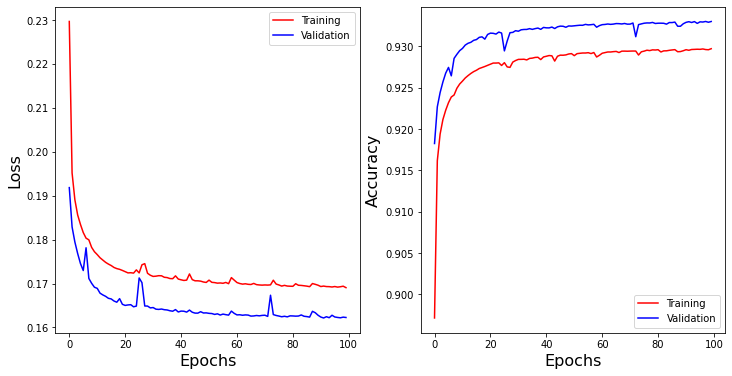

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(len(loss))

fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

ax1.plot(epochs, loss, 'r', label='Training')
ax1.plot(epochs, val_loss, 'b', label='Validation')
ax1.set_xlabel('Epochs', size=16)
ax1.set_ylabel('Loss', size=16)
ax1.legend()

ax2.plot(epochs, accuracy, 'r', label='Training')
ax2.plot(epochs, val_accuracy, 'b', label='Validation')
ax2.set_xlabel('Epochs', size=16)
ax2.set_ylabel('Accuracy', size=16)
ax2.legend()
plt.show()

> The model successfully predicts previous states of oscillating and static patterns such as gliders, blinkers, blocks... However, as soon as patterns get complex prediction become invalid as we can see in the last sample board. Single cells may randomly appear in parent board : the model predictions don't follow GOL rules.
We can confirm this by using forward GOL model on predicted parent boards and see whether the output matches label boards.

1/1 [==============================] - 0s 61ms/step - loss: 0.0332 - accuracy: 0.9904


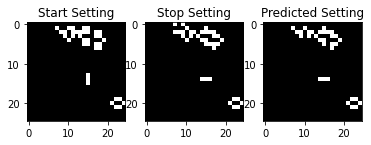

1/1 [==============================] - 0s 15ms/step - loss: 0.2189 - accuracy: 0.9456


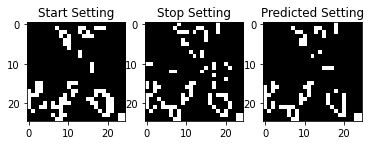

1/1 [==============================] - 0s 15ms/step - loss: 0.1656 - accuracy: 0.9408


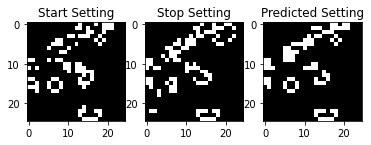

1/1 [==============================] - 0s 15ms/step - loss: 0.3438 - accuracy: 0.8624


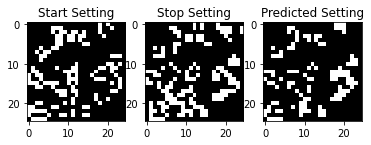

1/1 [==============================] - 0s 14ms/step - loss: 0.1635 - accuracy: 0.9232


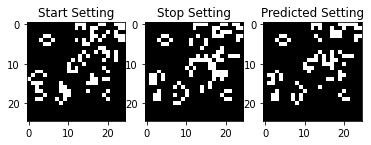

In [ ]:
for example in range(len(X_train[50:55])):

    img_sample = X_test[example]
    out_sample = Y_test[example]

    Model.evaluate(img_sample.reshape((-1, 25, 25, 1)), out_sample.reshape((-1, 25, 25, 1)))
    predicted = Model.predict(X_test[example].reshape((-1, 25, 25, 1)))

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

    ax1.imshow((img_sample.reshape(25, 25)), cmap="gray")
    ax1.set_title("Start Setting")

    ax2.imshow((out_sample.reshape(25, 25)), cmap="gray")
    ax2.set_title("Stop Setting")

    ax3.imshow((predicted.reshape(25, 25) >= 0.5), cmap="gray")
    ax3.set_title("Predicted Setting")
    plt.show()

In [ ]:
tf.keras.models.save_model(Model, '/content/drive/MyDrive/reverse_gol_model')